# Disruption on education by COVID-19 and anxiety/depression trends

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats import chisquare

sns.set(style="white")
%matplotlib inline

In [2]:
df_census = pd.read_csv('../data/interim/pulse2020_puf_all.csv')

In [3]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197365 entries, 0 to 1197364
Columns: 207 entries, SCRAM to depression_disorder
dtypes: bool(2), float64(203), object(2)
memory usage: 1.8+ GB


In [4]:
df_census.columns

Index(['SCRAM', 'WEEK', 'EST_ST', 'EST_MSA', 'PWEIGHT', 'ABIRTH_YEAR',
       'EGENDER', 'AGENDER', 'RHISPANIC', 'AHISPANIC',
       ...
       'PSWHYCHG3', 'PSWHYCHG4', 'PSWHYCHG5', 'PSWHYCHG6', 'PSWHYCHG7',
       'PSWHYCHG8', 'PSWHYCHG9', 'AGE', 'anxiety_disorder',
       'depression_disorder'],
      dtype='object', length=207)

In [5]:
df_census['COUNTER'] = 1

In [6]:
df_surveyed = df_census.groupby('SCRAM').count().reset_index()

Here, we have people participating once on the survey and other more than once. Splitting them,

In [7]:
df_scrams_once = df_surveyed[df_surveyed.COUNTER == 1]
df_scrams_more = df_surveyed[df_surveyed.COUNTER > 1]

In [8]:
df_scrams_more.head()

,SCRAM,WEEK,EST_ST,EST_MSA,PWEIGHT,ABIRTH_YEAR,EGENDER,AGENDER,RHISPANIC,AHISPANIC,...,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,AGE,anxiety_disorder,depression_disorder,COUNTER
1,V010000001S10011900470112,3,3,0,3,3,3,3,3,3,...,0,0,0,0,0,0,3,3,3,3
12,V010000002S01021474150113,3,3,1,3,3,3,3,3,3,...,0,0,0,0,0,0,3,3,3,3
14,V010000002S02020239610113,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2
16,V010000002S02020381430111,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2
22,V010000002S02022254170111,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,2,2,2,2


Extracting interesting variables for Educational Analysis:

In [9]:
education_df = df_census.loc[:, ['SCRAM', 'COUNTER', 'WEEK', 'EST_ST', 'RRACE', 'RHISPANIC', 'EGENDER', 'EEDUC', 'AGE',
                                'ENROLL1', 'ENROLL2', 'ENROLL3', 
                                'TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5',
                                'COMPAVAIL', 'COMP1', 'COMP2', 'COMP3', 'INTRNTAVAIL',
                                'INTRNT1', 'INTRNT2', 'INTRNT3', 
                                'TSCHLHRS', 'TTCH_HRS', 'THHLD_NUMKID', 'INCOME', 'anxiety_disorder', 'depression_disorder']]

In [10]:
anxiety_overtime = education_df.groupby(['anxiety_disorder', 'WEEK']).count().COUNTER
anxiety_overtime/len(education_df)

anxiety_disorder  WEEK      
False             2020-04-23    0.045642
                  2020-05-07    0.026184
                  2020-05-14    0.083103
                  2020-05-21    0.064477
                  2020-05-28    0.066144
                  2020-06-04    0.051953
                  2020-06-11    0.044484
                  2020-06-18    0.065107
                  2020-06-25    0.058772
                  2020-07-02    0.053549
                  2020-07-09    0.053409
                  2020-07-16    0.050115
                  2020-08-19    0.067648
True              2020-04-23    0.016505
                  2020-05-07    0.008890
                  2020-05-14    0.027941
                  2020-05-21    0.020054
                  2020-05-28    0.021604
                  2020-06-04    0.017618
                  2020-06-11    0.016878
                  2020-06-18    0.025143
                  2020-06-25    0.023628
                  2020-07-02    0.022256
                  2020-07-09

In [11]:
y1 = anxiety_overtime[0]
y2 = anxiety_overtime[1]

a = anxiety_overtime.reset_index()
x = list(a.WEEK[:13])

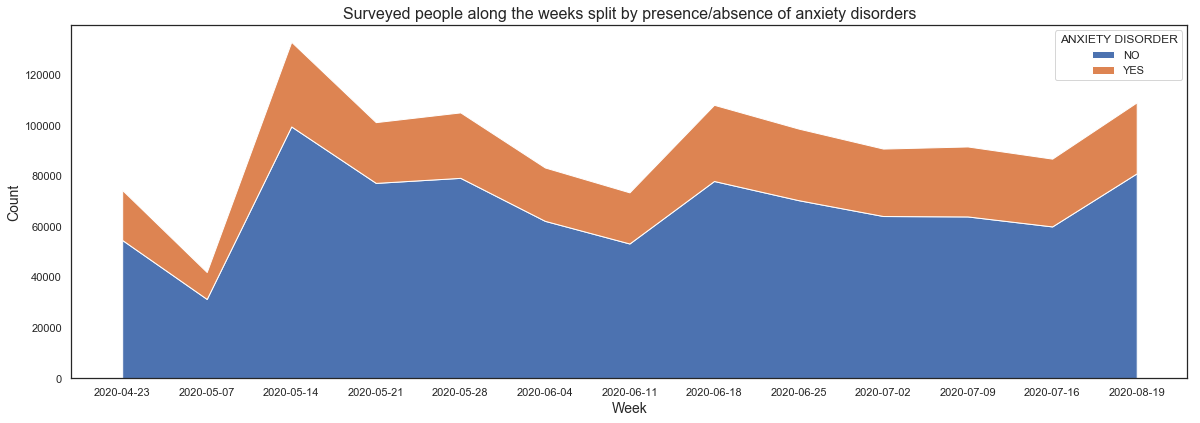

In [12]:
sns.set(style="white")

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2], 
                  labels=['A','B'])
_ = plt.title('Surveyed people along the weeks split by presence/absence of anxiety disorders', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Count', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ANXIETY DISORDER', loc='upper right', labels=['NO', 'YES'])
_ = plt.show()

In [13]:
def get_ct(df, var):
    ct_res = pd.crosstab(index=[df[var]], columns=df['anxiety_disorder'], margins=True)
    ct_res['True(%)'] = round( ct_res[True]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [14]:
ct_anx = get_ct(education_df, 'WEEK')
ct_anx['ptc_change'] = ct_anx['True(%)'].pct_change()
ct_anx['cumsum_pct_change'] = ct_anx['ptc_change'].cumsum()

In [15]:
ct_anx

anxiety_disorder,False,True,True(%),ptc_change,cumsum_pct_change
WEEK,,,,,
2020-04-23,54650,19763,26.56,NaN,NaN
2020-05-07,31352,10644,25.35,-0.045557,-0.045557
2020-05-14,99505,33456,25.16,-0.007495,-0.053052
2020-05-21,77203,24012,23.72,-0.057234,-0.110286
2020-05-28,79198,25868,24.62,0.037943,-0.072343
2020-06-04,62207,21095,25.32,0.028432,-0.043911
2020-06-11,53263,20209,27.51,0.086493,0.042582
2020-06-18,77957,30105,27.86,0.012723,0.055304
2020-06-25,70372,28291,28.67,0.029074,0.084378


In [16]:
def get_ct_dep(df, var):
    ct_res = pd.crosstab(index=[df[var]], columns=df['depression_disorder'], margins=True)
    ct_res['True(%)'] = round( ct_res[True]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [17]:
ct_dep = get_ct_dep(education_df, 'WEEK')
ct_dep['ptc_change'] = ct_dep['True(%)'].pct_change()
ct_dep['cumsum_pct_change'] = ct_dep['ptc_change'].cumsum()

In [18]:
ct_dep

depression_disorder,False,True,True(%),ptc_change,cumsum_pct_change
WEEK,,,,,
2020-04-23,60457,13956,18.75,NaN,NaN
2020-05-07,34034,7962,18.96,0.011200,0.011200
2020-05-14,108318,24643,18.53,-0.022679,-0.011479
2020-05-21,82983,18232,18.01,-0.028063,-0.039542
2020-05-28,85744,19322,18.39,0.021099,-0.018443
2020-06-04,68089,15213,18.26,-0.007069,-0.025512
2020-06-11,59197,14275,19.43,0.064074,0.038563
2020-06-18,86451,21611,20.00,0.029336,0.067899
2020-06-25,78067,20596,20.88,0.044000,0.111899


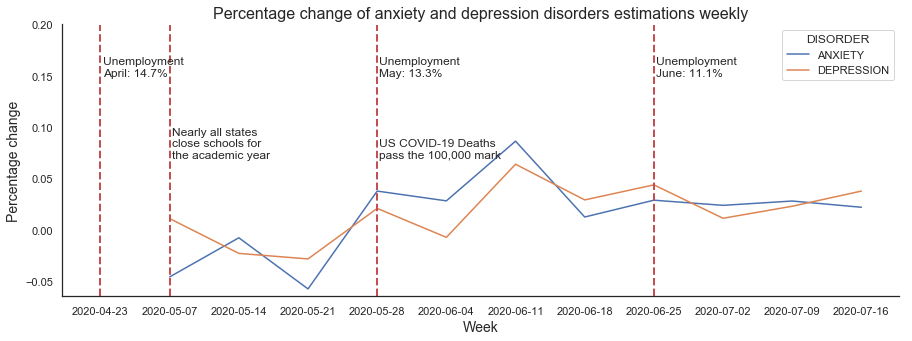

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = plt.plot(ct_anx['ptc_change'][:12])
_ = plt.plot(ct_dep['ptc_change'][:12])
_ = plt.title('Percentage change of anxiety and depression disorders estimations weekly', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage change', size=14)

_ = plt.axvline(x=0, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(0.03, 0.15, 'Unemployment \nApril: 14.7%')

_ = plt.axvline(x=1, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(1.03, 0.07, 'Nearly all states \nclose schools for \nthe academic year')

_ = plt.axvline(x=4, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(4.03, 0.07, 'US COVID-19 Deaths \npass the 100,000 mark')
_ = plt.text(4.03, 0.15, 'Unemployment \nMay: 13.3%')

_ = plt.axvline(x=8, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(8.03, 0.15, 'Unemployment \nJune: 11.1%')


_ = plt.ylim(top=0.2)
_ = plt.legend(title='DISORDER', loc='upper right', labels=['ANXIETY', 'DEPRESSION'])



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

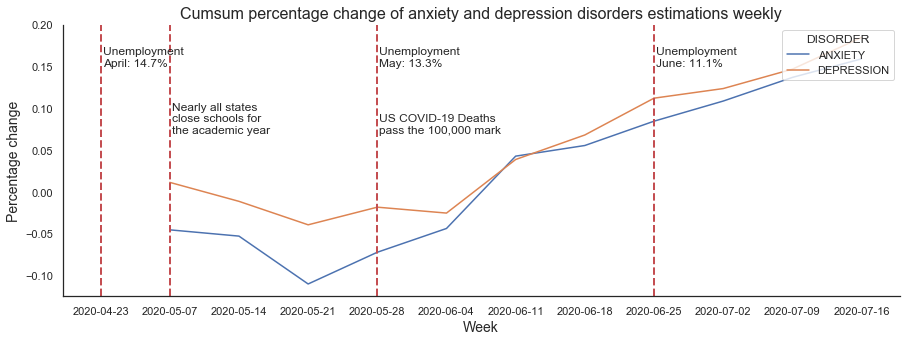

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = plt.plot(ct_anx['cumsum_pct_change'][:12])
_ = plt.plot(ct_dep['cumsum_pct_change'][:12])
_ = plt.title('Cumsum percentage change of anxiety and depression disorders estimations weekly', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage change', size=14)

_ = plt.axvline(x=0, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(0.03, 0.15, 'Unemployment \nApril: 14.7%')

_ = plt.axvline(x=1, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(1.03, 0.07, 'Nearly all states \nclose schools for \nthe academic year')

_ = plt.axvline(x=4, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(4.03, 0.07, 'US COVID-19 Deaths \npass the 100,000 mark')
_ = plt.text(4.03, 0.15, 'Unemployment \nMay: 13.3%')

_ = plt.axvline(x=8, linewidth=2, color='r', linestyle='--')  #horizontal line
_ = plt.text(8.03, 0.15, 'Unemployment \nJune: 11.1%')


_ = plt.ylim(top=0.2)
_ = plt.legend(title='DISORDER', loc='upper right', labels=['ANXIETY', 'DEPRESSION'])



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Anxiety/depression disorders by gender:

In [21]:
education_df.groupby(['EGENDER']).count().COUNTER

EGENDER
1.0    485431
2.0    711934
Name: COUNTER, dtype: int64

In [22]:
anxiety_gender = education_df.groupby(['anxiety_disorder','EGENDER']).count().COUNTER
anxiety_gender

anxiety_disorder  EGENDER
False             1.0        380107
                  2.0        494673
True              1.0        105324
                  2.0        217261
Name: COUNTER, dtype: int64

In [23]:
anxiety_gender_pct = anxiety_gender/anxiety_gender.groupby(level=[0]).sum()
anxiety_gender_pct

anxiety_disorder  EGENDER
False             1.0        0.434517
                  2.0        0.565483
True              1.0        0.326500
                  2.0        0.673500
Name: COUNTER, dtype: float64

### STATISTICAL TEST 1: Is this difference statistically significant? Is there a relationship between anxiety disorder and gender?

Between the surveyed reporting/not reporting anxiety disorders, 67.3% and 56.5% are women, respectively. We proceed to apply a chi-squared test comparing the frecuency of anxiety disorders by gender. **The statement of the null hypothesis is that no relationship exists on the categorical variables (gender-anxiety). It means, they are independent.**

In [24]:
chisquare(f_obs=[380107,494673], f_exp=[105324, 105324])

Power_divergenceResult(statistic=2156187.961813072, pvalue=0.0)

In [25]:
g, p, dof, expctd = chi2_contingency(pd.crosstab(index=education_df['EGENDER'], columns=education_df['anxiety_disorder']))
print(g, p)

11407.003314519754 0.0


**Using a confidence level of 0.05%, we reject the null hypothesis of no relationship because p_value is less than 0.05. In other words, the p_value is statistically significant and indicates strong evidence to reject the null hypothesis. Let's check the depression disorder:**

In [26]:
g, p, dof, expctd = chi2_contingency(pd.crosstab(index=education_df['EGENDER'], columns=education_df['depression_disorder']))
print(g, p)

3220.1074323755192 0.0


# Families with children enrolled in public private schools, homeschool or no enrolled

<div class="alert alert-block alert-warning">
<b>Considerations:</b> To following, we define edu_df dataframe that drops the variable WEEK_DT to filter people surveyed twice or more times if all the rest of school related variables keep the same. Instead, when we analyze trends along the time, we use the education_df dataframe with the timing variable included.
</div>

For no timing analysis, let's drop duplicates columns

In [27]:
edu_df = education_df.drop(['WEEK'], axis=1).drop_duplicates()

In [28]:
print('Duplicates rows: {}'.format(len(education_df)-len(edu_df)))

Duplicates rows: 98474


Number of people under 18 years old at home

In [29]:
edu_df.groupby('THHLD_NUMKID').count().COUNTER

THHLD_NUMKID
0.0    681716
1.0    177967
2.0    151415
3.0     58304
4.0     19611
5.0      9878
Name: COUNTER, dtype: int64

In [30]:
df_under18 = edu_df.groupby('THHLD_NUMKID').count().COUNTER
pct_under18 = df_under18/sum(df_under18)
pct_under18

THHLD_NUMKID
0.0    0.620367
1.0    0.161951
2.0    0.137789
3.0    0.053057
4.0    0.017846
5.0    0.008989
Name: COUNTER, dtype: float64

In [31]:
print('Percentage of household without members under 18 years old: {}\n'.format(pct_under18[0]))
print('Percentage of household with members under 18 years old: {}'.format(sum(pct_under18[1:])))

Percentage of household without members under 18 years old: 0.6203672611751302

Percentage of household with members under 18 years old: 0.3796327388248698


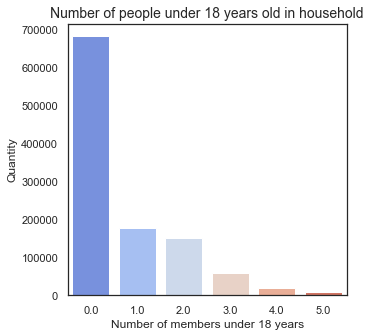

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.countplot(x='THHLD_NUMKID', data=edu_df, palette='coolwarm')
_ = plt.title('Number of people under 18 years old in household', size=14)
_ = plt.xlabel('Number of members under 18 years', size=12)
_ = plt.ylabel('Quantity', size=12)

In [33]:
x = edu_df.loc[:, ['ENROLL1', 'ENROLL2', 'ENROLL3']].idxmax(axis=1)
edu_df['ENROLL_TYPE'] = x

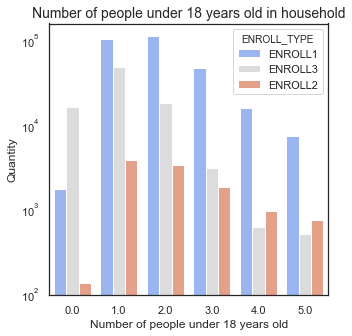

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.countplot(x='THHLD_NUMKID', data=edu_df, hue= 'ENROLL_TYPE', palette='coolwarm')
_ = plt.title('Number of people under 18 years old in household', size=14)
_ = plt.xlabel('Number of people under 18 years old', size=12)
_ = plt.ylabel('Quantity', size=12)
_ = plt.yscale("log")

It suggests that some households don't have members under 18 years old, but the surveyed person is a parent with children living somewhere else. Before splitting the population by enroll type of the children, we check that the variable `THHLD_NUMKID` is upper than 0.

<div class="alert alert-block alert-warning">
<b>Assumption</b> The analysis of type of school enrollment only includes the surveyed that declared living with under 18 years old members at home. 
</div>

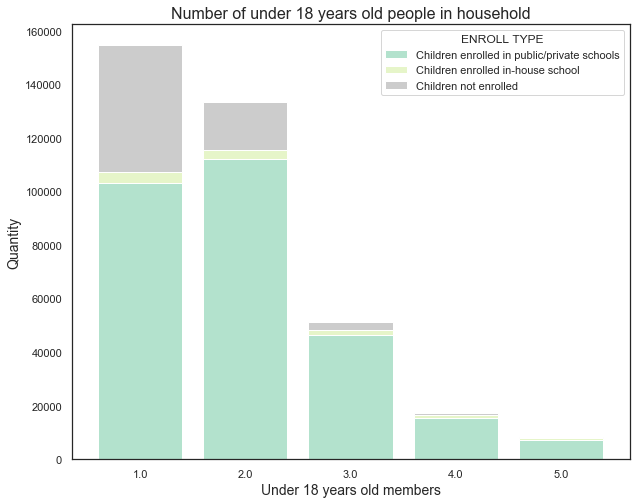

In [35]:
test1 = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['THHLD_NUMKID', 'ENROLL_TYPE',])['COUNTER'].count().unstack('ENROLL_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
_ = test1.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 3))
_ = plt.title('Number of under 18 years old people in household', size=16)
_ = plt.xlabel('Under 18 years old members', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper right', labels=['Children enrolled in public/private schools', 
                                                          'Children enrolled in-house school', 
                                                          'Children not enrolled'])

In [36]:
edu_df[edu_df.THHLD_NUMKID > 0].groupby(['THHLD_NUMKID', 'ENROLL_TYPE']).count().COUNTER

THHLD_NUMKID  ENROLL_TYPE
1.0           ENROLL1        103337
              ENROLL2          3852
              ENROLL3         47438
2.0           ENROLL1        112208
              ENROLL2          3312
              ENROLL3         18015
3.0           ENROLL1         46384
              ENROLL2          1822
              ENROLL3          3104
4.0           ENROLL1         15604
              ENROLL2           950
              ENROLL3           614
5.0           ENROLL1          7239
              ENROLL2           742
              ENROLL3           504
Name: COUNTER, dtype: int64

In [37]:
qtx_enroll = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['ENROLL_TYPE']).count().COUNTER

In [38]:
ptc_enroll = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['ENROLL_TYPE']).count().COUNTER/edu_df[edu_df.THHLD_NUMKID > 0].count().COUNTER

In [39]:
ptc_enroll

ENROLL_TYPE
ENROLL1    0.682620
ENROLL2    0.025596
ENROLL3    0.167016
Name: COUNTER, dtype: float64

In [40]:
enroll = pd.concat([qtx_enroll, ptc_enroll], axis=1)

In [41]:
print('Children enrolled in public or private school : {} \nRelated to the whole population: {:.2f}\n'.format(enroll.iloc[0, 0], enroll.iloc[0, 1]))
print('Children in school housing : {} \nand Related to the whole population: {:.2f}\n'.format(enroll.iloc[1, 0], enroll.iloc[1, 1]))
print('Children not enrolled in school : {} \nRelated to the whole population: {:.2f}\n'.format(enroll.iloc[2, 0], enroll.iloc[2, 1]))

Children enrolled in public or private school : 284772 
Related to the whole population: 0.68

Children in school housing : 10678 
and Related to the whole population: 0.03

Children not enrolled in school : 69675 
Related to the whole population: 0.17



In [42]:
def get_ct_multi(df, var, var1):
    ct_res = pd.crosstab(index=[df[var], df[var1]], columns=df['anxiety_disorder'], margins=True)
    ct_res['True(%)'] = round( ct_res[True]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [43]:
ct_munkid = get_ct_multi(edu_df, 'THHLD_NUMKID', 'ENROLL_TYPE')

In [44]:
ct_munkid

anxiety_disorder           False    True  True(%)
THHLD_NUMKID ENROLL_TYPE                         
0.0          ENROLL1        1134     611    35.01
             ENROLL2         100      34    25.37
             ENROLL3       11730    4429    27.41
1.0          ENROLL1       67078   36259    35.09
             ENROLL2        2296    1556    40.39
             ENROLL3       31940   15498    32.67
2.0          ENROLL1       74722   37486    33.41
             ENROLL2        2170    1142    34.48
             ENROLL3       12444    5571    30.92
3.0          ENROLL1       30868   15516    33.45
             ENROLL2        1250     572    31.39
             ENROLL3        2135     969    31.22
4.0          ENROLL1       10291    5313    34.05
             ENROLL2         677     273    28.74
             ENROLL3         391     223    36.32
5.0          ENROLL1        4737    2502    34.56
             ENROLL2         542     200    26.95
             ENROLL3         285     219    43.45
All                       254790  128373    33.50

## 1. Insights:

- 62% of households don't have under 18 years old members (around 680k).
- 29.8% of households have 1 or 2 under 18 years old people.
- 7.8% of houses have 3, 4 or 5 under 18 years old people members.

From the universe of surveyed people that have under 18 years old people at home, 
- 68% of surveyed have children enrolled in public or private schools.
- 3% of surveyed enrolled their kids in schools (household). It means, home-schooled.

- Between the surveyed people that have under 18 years old people at home, 17% don't have children enrolled people in any school program.

#### HOW IS THE ANXIETY OF THE GROUP WHITHOUT ENROLLED CHILDREN RELATED TO THE GROUPS WITH UNDER 18 YEARS OLD MEMBERS ENROLLED? (COMPARE BY GENDER, WOMEN AND MEN SURVEYED)

In [45]:
#Filters: THHLD_NUMKID > 0
#All following scenarios consider under 18 years old members at home
scenario_base = edu_df[(edu_df.THHLD_NUMKID > 0)]

## ANXIETY AND DEPRESSION ESTIMATORS

In [46]:
df_base = scenario_base.groupby(['anxiety_disorder', 'depression_disorder']).count().COUNTER
df_base/df_base.sum()

anxiety_disorder  depression_disorder
False             False                  0.662137
                  True                   0.034767
True              False                  0.135483
                  True                   0.167613
Name: COUNTER, dtype: float64

## 2. Insights

- 66% of surveyed with members under 18 years old at home don't show signs of anxiety and depression disorders.
- 3.47 % of surveyed presents syntoms of depression but not anxiety disorders
- 13.5% of surveyed presents syntoms of anxiety but not depression disorders
- 16.76% of surveyed show signs of anxiety and depression dissorders.

In [47]:
df_base_plot = df_base/df_base.sum()
df = df_base_plot.reset_index()

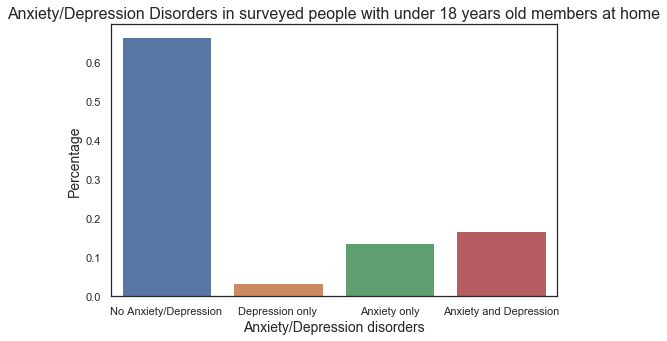

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['No Anxiety/Depression', 
           'Depression only', 
           'Anxiety only',
           'Anxiety and Depression']

_ = sns.barplot(data=df, y='COUNTER', x=df.index)
_ = plt.xticks(df.index, labels)
_ = plt.xlabel('Anxiety/Depression disorders', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.title('Anxiety/Depression Disorders in surveyed people with under 18 years old members at home', size=16)

In [49]:
# Along time analysis, filtering households without under 18 years old members
scenario_timebase = education_df[(education_df.THHLD_NUMKID > 0)].reset_index()

In [50]:
aux = scenario_timebase.loc[:, ['ENROLL1', 'ENROLL2', 'ENROLL3']].idxmax(axis=1)
scenario_timebase['ENROLL_TYPE'] = aux

In [51]:
anxiety_timebase = scenario_timebase.groupby(['anxiety_disorder', 'ENROLL_TYPE', 'WEEK']).count().COUNTER
weekly_anxiety_enroll = anxiety_timebase/anxiety_timebase.groupby(level=[2]).sum()
weekly_anxiety_enroll_ri = weekly_anxiety_enroll.reset_index()
weekly_anxiety_enroll_anxiety = weekly_anxiety_enroll_ri[weekly_anxiety_enroll_ri.anxiety_disorder == True]

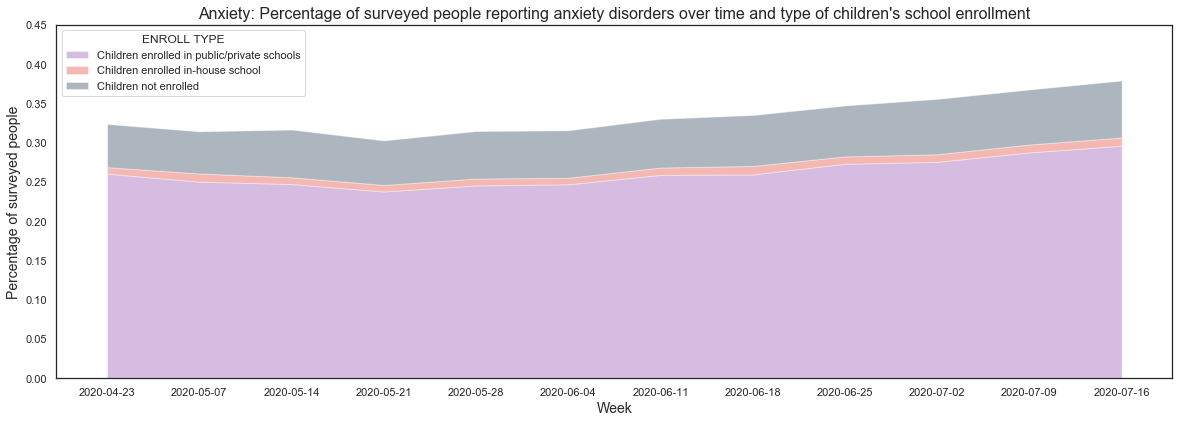

In [52]:
y1=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL1'].COUNTER[:-1])
y2=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL2'].COUNTER[:-1])
y3=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL3'].COUNTER[:-1])
x = list(weekly_anxiety_enroll_anxiety.WEEK[:12])

sns.set(style="white")
pal = ["#9b59b6", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title("Anxiety: Percentage of surveyed people reporting anxiety disorders over time and type of children's school enrollment", size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage of surveyed people', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper left', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])
_ = plt.ylim(0, 0.45)
_ = plt.show()

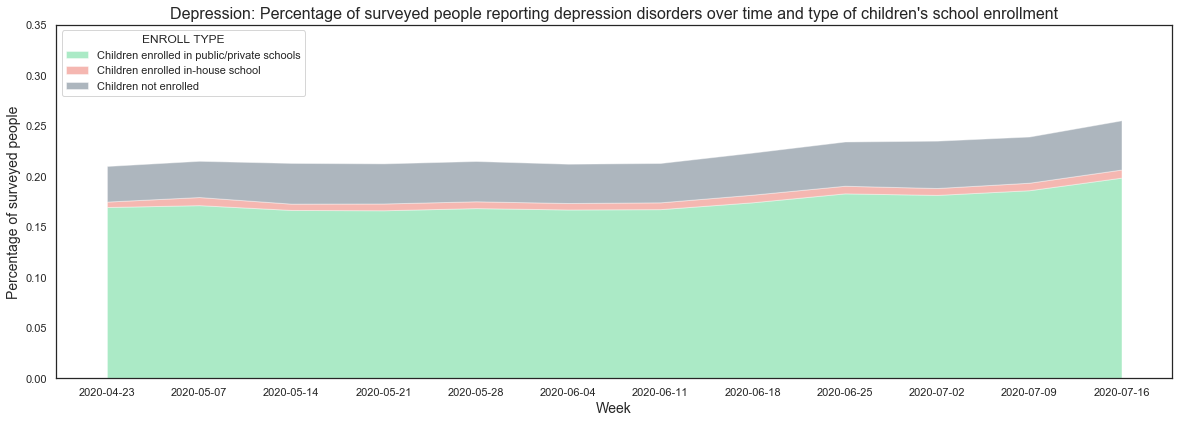

In [53]:
depression_timebase = scenario_timebase.groupby(['depression_disorder', 'ENROLL_TYPE', 'WEEK']).count().COUNTER
depression_timebase_enroll = depression_timebase/anxiety_timebase.groupby(level=[2]).sum()
depression_timebase_enroll_ri = depression_timebase_enroll.reset_index()
weekly_dep = depression_timebase_enroll_ri[depression_timebase_enroll_ri.depression_disorder == True]

y1=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL1'].COUNTER[:-1])
y2=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL2'].COUNTER[:-1])
y3=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL3'].COUNTER[:-1])
x = list(weekly_dep.WEEK[:12])

sns.set(style="white")
pal = ["#2ecc71", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title("Depression: Percentage of surveyed people reporting depression disorders over time and type of children's school enrollment", size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage of surveyed people', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper left', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])
_ = plt.ylim(0, 0.35)
_ = plt.show()

Analysis of anxiety and depression disorders by enrollment type and gender of surveyed person:

In [54]:
df_anxious = scenario_base.groupby(['anxiety_disorder', 'ENROLL_TYPE']).count().COUNTER
df_anxious

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        187696
                  ENROLL2          6935
                  ENROLL3         47195
True              ENROLL1         97076
                  ENROLL2          3743
                  ENROLL3         22480
Name: COUNTER, dtype: int64

In [55]:
df_anxious/df_anxious.groupby(level=[1]).sum()

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        0.659110
                  ENROLL2        0.649466
                  ENROLL3        0.677359
True              ENROLL1        0.340890
                  ENROLL2        0.350534
                  ENROLL3        0.322641
Name: COUNTER, dtype: float64

In [56]:
df_anxious/df_anxious.groupby(level=[0]).sum()

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        0.776161
                  ENROLL2        0.028678
                  ENROLL3        0.195161
True              ENROLL1        0.787322
                  ENROLL2        0.030357
                  ENROLL3        0.182321
Name: COUNTER, dtype: float64

In [57]:
df_dep = scenario_base.groupby(['depression_disorder', 'ENROLL_TYPE']).count().COUNTER
df_dep

depression_disorder  ENROLL_TYPE
False                ENROLL1        220175
                     ENROLL2          7926
                     ENROLL3         54844
True                 ENROLL1         64597
                     ENROLL2          2752
                     ENROLL3         14831
Name: COUNTER, dtype: int64

In [58]:
df_dep/df_dep.groupby(level=[0]).sum()

depression_disorder  ENROLL_TYPE
False                ENROLL1        0.778155
                     ENROLL2        0.028013
                     ENROLL3        0.193833
True                 ENROLL1        0.786043
                     ENROLL2        0.033487
                     ENROLL3        0.180470
Name: COUNTER, dtype: float64

In [59]:
df_anxious_gender = scenario_base.groupby(['anxiety_disorder', 'ENROLL_TYPE', 'EGENDER']).count().COUNTER
df_anxious_gender

anxiety_disorder  ENROLL_TYPE  EGENDER
False             ENROLL1      1.0         73133
                               2.0        114563
                  ENROLL2      1.0          2950
                               2.0          3985
                  ENROLL3      1.0         20209
                               2.0         26986
True              ENROLL1      1.0         27027
                               2.0         70049
                  ENROLL2      1.0          1256
                               2.0          2487
                  ENROLL3      1.0          7610
                               2.0         14870
Name: COUNTER, dtype: int64

In [60]:
df_anxious_gender = df_anxious_gender/df_anxious_gender.groupby(level=[2]).sum()

In [61]:
df_anxious_gender

anxiety_disorder  ENROLL_TYPE  EGENDER
False             ENROLL1      1.0        0.553262
                               2.0        0.491813
                  ENROLL2      1.0        0.022317
                               2.0        0.017107
                  ENROLL3      1.0        0.152884
                               2.0        0.115850
True              ENROLL1      1.0        0.204463
                               2.0        0.300717
                  ENROLL2      1.0        0.009502
                               2.0        0.010677
                  ENROLL3      1.0        0.057571
                               2.0        0.063836
Name: COUNTER, dtype: float64

In [62]:
#df_anxious_gender = df_anxious_gender.iloc[df_anxious_gender.index.get_level_values('anxiety_disorder') == True]

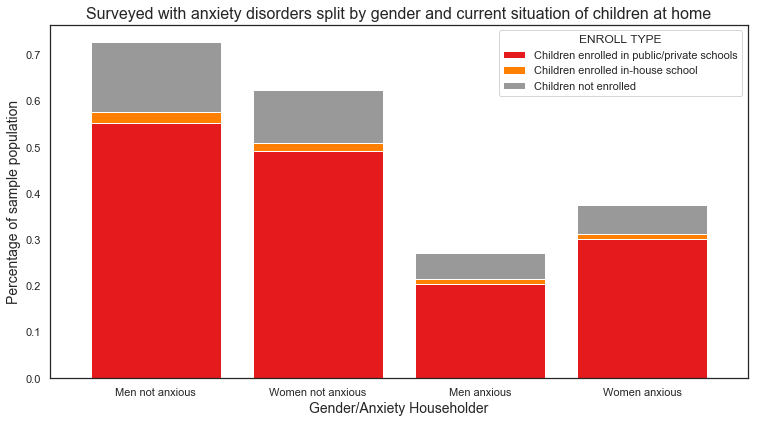

In [63]:
test3 = df_anxious_gender.unstack('ENROLL_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(12.5, 6.5))
_ = test3.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1', 3))
_ = plt.title('Surveyed with anxiety disorders split by gender and current situation of children at home', size=16)
_ = plt.xlabel('Gender/Anxiety Householder', size=14)
_ = plt.ylabel('Percentage of sample population', size=14)
_ = plt.xticks(np.arange(4),('Men not anxious', 'Women not anxious', 'Men anxious', 'Women anxious'), rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper right', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])

In [64]:
ct_enrollgen = get_ct_multi(edu_df, 'EGENDER', 'ENROLL_TYPE')

In [65]:
ct_enrollgen

anxiety_disorder      False    True  True(%)
EGENDER ENROLL_TYPE                         
1.0     ENROLL1       73653   27248    27.00
        ENROLL2        2993    1265    29.71
        ENROLL3       25602    9210    26.46
2.0     ENROLL1      115177   70439    37.95
        ENROLL2        4042    2512    38.33
        ENROLL3       33323   17699    34.69
All                  254790  128373    33.50

In [66]:
ct_engen = ct_enrollgen.reset_index()

In [67]:
ratio1 = ct_engen[(ct_engen.EGENDER == 2) & (ct_engen.ENROLL_TYPE == 'ENROLL1')]['True(%)'].values/ct_engen[(ct_engen.EGENDER == 1) & (ct_engen.ENROLL_TYPE == 'ENROLL1')]['True(%)'].values
print('Women ansiety ENROLL1/Men ansiety ENROLL1: {}'.format(np.round(ratio1, 2)))

Women ansiety ENROLL1/Men ansiety ENROLL1: [1.41]


In [68]:
ratio1 = ct_engen[(ct_engen.EGENDER == 2) & (ct_engen.ENROLL_TYPE == 'ENROLL2')]['True(%)'].values/ct_engen[(ct_engen.EGENDER == 1) & (ct_engen.ENROLL_TYPE == 'ENROLL2')]['True(%)'].values
print('Women ansiety ENROLL2/Men ansiety ENROLL2: {}'.format(np.round(ratio1, 2)))

Women ansiety ENROLL2/Men ansiety ENROLL2: [1.29]


In [69]:
ratio1 = ct_engen[(ct_engen.EGENDER == 2) & (ct_engen.ENROLL_TYPE == 'ENROLL3')]['True(%)'].values/ct_engen[(ct_engen.EGENDER == 1) & (ct_engen.ENROLL_TYPE == 'ENROLL3')]['True(%)'].values
print('Women ansiety ENROLL3/Men ansiety ENROLL3: {}'.format(np.round(ratio1, 2)))

Women ansiety ENROLL3/Men ansiety ENROLL3: [1.31]


In [70]:
def get_3variables(df, var, var1, var2):
    ct_res = pd.crosstab(index=[df[var], df[var1], df[var2]], columns=df['depression_disorder'], margins=True)
    ct_res['True(%)'] = round( ct_res[True]/ct_res['All']*100, 2)
    ct_res['Neg(%)'] = round( ct_res[False]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [71]:
get_3variables(edu_df, 'EGENDER', 'ENROLL_TYPE', 'THHLD_NUMKID')

depression_disorder                False   True  True(%)  Neg(%)
EGENDER ENROLL_TYPE THHLD_NUMKID                                
1.0     ENROLL1     0.0              568    173    23.35   76.65
                    1.0            28135   7244    20.48   79.52
                    2.0            33471   7445    18.20   81.80
                    3.0            13212   3005    18.53   81.47
                    4.0             4188   1036    19.83   80.17
                    5.0             1918    506    20.87   79.13
        ENROLL2     0.0               42     10    19.23   80.77
                    1.0              982    368    27.26   72.74
                    2.0             1078    296    21.54   78.46
                    3.0              587    141    19.37   80.63
                    4.0              339     85    20.05   79.95
                    5.0              267     63    19.09   80.91
        ENROLL3     0.0             5650   1343    19.20   80.80
                    1.0            14936   3746    20.05   79.95
                    2.0             6037   1329    18.04   81.96
                    3.0              998    267    21.11   78.89
                    4.0              196     70    26.32   73.68
                    5.0              145     95    39.58   60.42
2.0     ENROLL1     0.0              700    304    30.28   69.72
                    1.0            49871  18087    26.61   73.39
                    2.0            54847  16445    23.07   76.93
                    3.0            23129   7038    23.33   76.67
                    4.0             7811   2569    24.75   75.25
                    5.0             3593   1222    25.38   74.62
        ENROLL2     0.0               63     19    23.17   76.83
                    1.0             1658    844    33.73   66.27
                    2.0             1430    508    26.21   73.79
                    3.0              828    266    24.31   75.69
                    4.0              428     98    18.63   81.37
                    5.0              329     83    20.15   79.85
        ENROLL3     0.0             7039   2127    23.21   76.79
                    1.0            22034   6722    23.38   76.62
                    2.0             8626   2023    19.00   81.00
                    3.0             1463    376    20.45   79.55
                    4.0              244    104    29.89   70.11
                    5.0              165     99    37.50   62.50
All                               297007  86156    22.49   77.51

### STATISTICAL TEST 2:  Do anxiety levels differ significantly across the enroll cohorts?

In [72]:
pd.crosstab(index=scenario_base['ENROLL_TYPE'], columns=scenario_base['anxiety_disorder'])

anxiety_disorder,False,True
ENROLL_TYPE,,
ENROLL1,187696,97076
ENROLL2,6935,3743
ENROLL3,47195,22480


In [73]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=scenario_base['ENROLL_TYPE'], columns=scenario_base['anxiety_disorder']))
print(chi2, p)

91.47029863215477 1.372388350845643e-20


**We found significant differences between the cohorts.**

The test does not tell us which pair of groups have anxiety ratios that are different from each other. To investigate these differences further, we are going to test if there is a significant difference in each pairwise comparison. To test this sequence of hypotheses we can use a variant of the chi-square:

https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_chisquare_allpairs.html

In [74]:
df_test_anx = pd.crosstab(index=[scenario_base['ENROLL_TYPE'], scenario_base['EGENDER']], 
                      columns=scenario_base['anxiety_disorder'])

In [75]:
chi2, p, dof, ex = chi2_contingency(df_test_anx, correction=False)
print(chi2, p)

4161.4078203127765 0.0


In [76]:
df_test_dep = pd.crosstab(index=[scenario_base['ENROLL_TYPE'], scenario_base['EGENDER']], 
                         columns=scenario_base['depression_disorder'])

In [77]:
chi2, p, dof, ex = chi2_contingency(df_test_dep, correction=False)
print(chi2, p)

1299.3338597766547 8.905115582028649e-279


In summary: we firstly detect differences in the anxiety and depression levels by gender and children's school enrollment. Then, we built cohorts using both variables, comparing the ratios of women and men affected by syntoms of anxiety and depression and the relationship with the type of enrollment. We got that the differences between the cohorts are significant.

# Impact on education-Classes

<div class="alert alert-block alert-warning">
<b>Assumption</b> According to the survey, the question about education-classes only was asked to surveyed who previously reported children on public and private schools (ENROLL1 variable).
The alternatives (not mutually excluyent) are the following:
    
- TEACH1: Pandemic impact on education-Classes normally taught in person at the school were cancelled.
- TEACH2: Pandemic impact on education-Classes normally taught in person moved to a distance learning format using online resources, either self-paced or in real time.
- TEACH3: Pandemic impact on education-Classes normally taught in person moved to a distance-learning format using paper materials sent home to children.
- TEACH4: Pandemic impact on education-Classes normally taught in person moved to some other way.
- TEACH5: Pandemic impact on education- There was no change because schools did not close.
</div>



In [78]:
# Only enroll1
edu_df2 = edu_df.copy()
edu_df2 = edu_df2[(edu_df2['ENROLL_TYPE'] == 'ENROLL1') & (edu_df2.THHLD_NUMKID > 0)]

In [79]:
len(edu_df2)

284772

### Using that information and to get clean results, we build the following scenarios to get excluyent options:

- Normally taught in person at the school classes were cancelled and surveyed didn't mentioned any learning format currently being used by the school.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning using only online resources.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning only using paper materials sent home to children.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning using both online resources and paper materials sent home to children.
- Normally taught in person at the school classes were cancelled and surveyed mentioned other learning strategy.
- School did not close
- None of the above options

In [80]:
def teaching_function(a, b, c, d, e):
    if (a == 1) & (b != 1) & (c != 1) & (d != 1) & (e != 1):
        return 'No classes'
    elif (b == 1) & (c != 1) & (d != 1) & (e != 1):
        return 'Remote Online Modality'
    elif (a != 1) & (b != 1) & (c != 1) & (d != 1) & (e == 1):
        return 'Normal classes'
    elif (b != 1) & (c == 1) & (e != 1):
        return 'Sent home Modality'
    elif (b == 1) & (e != 1):
        return 'Mix Remote Learning'
    elif (b != 1) & (c != 1) & (d == 1) & (e != 1):
        return 'Other'
    else:
        return 'NA'

In [81]:
edu_df2['TEACH_TYPE'] = edu_df2[['TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5']].apply(lambda x: teaching_function(x['TEACH1'], x['TEACH2'], x['TEACH3'], x['TEACH4'], x['TEACH5']), axis=1)


In [82]:
edu_df2.groupby('TEACH_TYPE').count().COUNTER

TEACH_TYPE
Mix Remote Learning        44210
NA                          3455
No classes                 31682
Normal classes              3617
Other                       8465
Remote Online Modality    177264
Sent home Modality         16079
Name: COUNTER, dtype: int64

In [83]:
teaching_modality = edu_df2.groupby('TEACH_TYPE').count().COUNTER.sort_values(ascending=False)
df_teaching_modes = teaching_modality/teaching_modality.sum()
df_teaching_modes

TEACH_TYPE
Remote Online Modality    0.622477
Mix Remote Learning       0.155247
No classes                0.111254
Sent home Modality        0.056463
Other                     0.029726
Normal classes            0.012701
NA                        0.012133
Name: COUNTER, dtype: float64

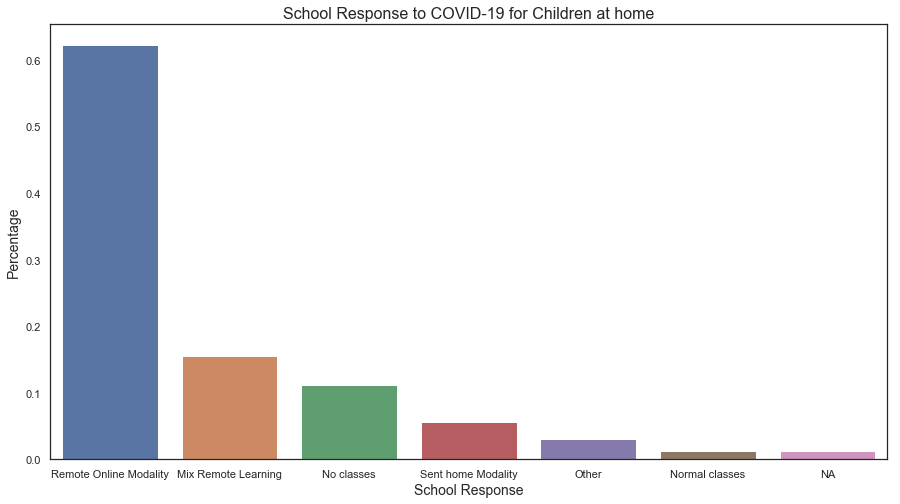

In [84]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.barplot(y=df_teaching_modes, x=df_teaching_modes.index)
_ = plt.xlabel('School Response', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.title('School Response to COVID-19 for Children at home', size=16)

In [85]:
#edu_df2[edu_df2.TEACH_TYPE == 'NA'].loc[:, ['TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5']]

In [86]:
teach_analysis = edu_df2[edu_df2.TEACH_TYPE != 'NA']
teach_analysis = teach_analysis.drop_duplicates()

In [87]:
len(teach_analysis)

281317

In [88]:
anxiety_teaching = teach_analysis.groupby(['anxiety_disorder', 'EGENDER', 'TEACH_TYPE']).count().COUNTER

In [89]:
anxiety_teaching

anxiety_disorder  EGENDER  TEACH_TYPE            
False             1.0      Mix Remote Learning        9758
                           No classes                 8279
                           Normal classes             1098
                           Other                      1921
                           Remote Online Modality    47546
                           Sent home Modality         3538
                  2.0      Mix Remote Learning       18601
                           No classes                10767
                           Normal classes             1532
                           Other                      3385
                           Remote Online Modality    72567
                           Sent home Modality         6441
True              1.0      Mix Remote Learning        3771
                           No classes                 4139
                           Normal classes              283
                           Other                       805
      

In [90]:
anxiety_teaching/anxiety_teaching.groupby(level=[0]).sum()

anxiety_disorder  EGENDER  TEACH_TYPE            
False             1.0      Mix Remote Learning       0.052623
                           No classes                0.044647
                           Normal classes            0.005921
                           Other                     0.010360
                           Remote Online Modality    0.256405
                           Sent home Modality        0.019080
                  2.0      Mix Remote Learning       0.100311
                           No classes                0.058064
                           Normal classes            0.008262
                           Other                     0.018255
                           Remote Online Modality    0.391338
                           Sent home Modality        0.034735
True              1.0      Mix Remote Learning       0.039329
                           No classes                0.043167
                           Normal classes            0.002951
                    

In [91]:
get_ct_multi(edu_df2, 'EGENDER', 'TEACH_TYPE')

anxiety_disorder                 False   True  True(%)
EGENDER TEACH_TYPE                                    
1.0     Mix Remote Learning       9758   3771    27.87
        NA                         993    386    27.99
        No classes                8279   4139    33.33
        Normal classes            1098    283    20.49
        Other                     1921    805    29.53
        Remote Online Modality   47546  16070    25.26
        Sent home Modality        3538   1573    30.78
2.0     Mix Remote Learning      18601  12080    39.37
        NA                        1270    806    38.82
        No classes               10767   8497    44.11
        Normal classes            1532    704    31.48
        Other                     3385   2354    41.02
        Remote Online Modality   72567  41081    36.15
        Sent home Modality        6441   4527    41.27
All                             187696  97076    34.09

In [92]:
def get_2variables(df, var, var1):
    ct_res = pd.crosstab(index=[df[var], df[var1]], columns=df['TEACH_TYPE'], margins=True)
    ct_res['Mix Remote Learning(%)'] = round( ct_res['Mix Remote Learning']/ct_res['All']*100, 2)
    ct_res['No classes(%)'] = round( ct_res['No classes']/ct_res['All']*100, 2)
    ct_res['NA(%)'] = round( ct_res['NA']/ct_res['All']*100, 2)
    ct_res['Normal classes(%)'] = round( ct_res['Normal classes']/ct_res['All']*100, 2)
    ct_res['Remote Online Modality(%)'] = round( ct_res['Remote Online Modality']/ct_res['All']*100, 2)    
    ct_res['Sent home Modality(%)'] = round( ct_res['Sent home Modality']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [93]:
df_test2 = get_2variables(edu_df2, 'EGENDER', 'anxiety_disorder')
df_test2

TEACH_TYPE                Mix Remote Learning    NA  No classes  \
EGENDER anxiety_disorder                                          
1.0     False                            9758   993        8279   
        True                             3771   386        4139   
2.0     False                           18601  1270       10767   
        True                            12080   806        8497   
All                                     44210  3455       31682   

TEACH_TYPE                Normal classes  Other  Remote Online Modality  \
EGENDER anxiety_disorder                                                  
1.0     False                       1098   1921                   47546   
        True                         283    805                   16070   
2.0     False                       1532   3385                   72567   
        True                         704   2354                   41081   
All                                 3617   8465                  177264   

TEACH_TYPE                Sent home Modality  Mix Remote Learning(%)  \
EGENDER anxiety_disorder                                               
1.0     False                           3538                   13.34   
        True                            1573                   13.95   
2.0     False                           6441                   16.24   
        True                            4527                   17.25   
All                                    16079                   15.52   

TEACH_TYPE                No classes(%)  NA(%)  Normal classes(%)  \
EGENDER anxiety_disorder                                            
1.0     False                     11.32   1.36               1.50   
        True                      15.31   1.43               1.05   
2.0     False                      9.40   1.11               1.34   
        True                      12.13   1.15               1.01   
All                               11.13   1.21               1.27   

TEACH_TYPE                Remote Online Modality(%)  Sent home Modality(%)  
EGENDER anxiety_disorder                                                    
1.0     False                                 65.01                   4.84  
        True                                  59.46                   5.82  
2.0     False                                 63.34                   5.62  
        True                                  58.65                   6.46  
All                                           62.25                   5.65

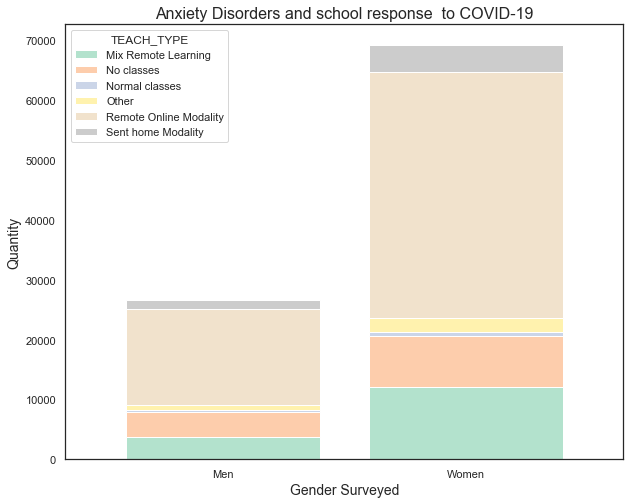

In [94]:
test4 = teach_analysis[teach_analysis.anxiety_disorder == True].groupby(['EGENDER', 'TEACH_TYPE']).count().COUNTER.unstack('TEACH_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
_ = test4.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 7))
_ = plt.title('Anxiety Disorders and school response  to COVID-19', size=16)
_ = plt.xlabel('Gender Surveyed', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.xticks(np.arange(2),('Men', 'Women'), rotation=0)

### STATISTICAL TEST 3: Statement: The levels of anxiety for anxious people differ significantly by gender when we analyse the type of format learning

Test using the anxious and not anxious groups:

In [95]:
df_test1_ax = pd.crosstab(index=[edu_df2['TEACH_TYPE'], edu_df2['EGENDER']], 
                           columns=edu_df2['anxiety_disorder'])

chi2_contingency(df_test1_ax, 
                  correction=False)

(4487.429396328961, 0.0, 13, array([[ 8917.0957257 ,  4611.9042743 ],
        [20222.14605369, 10458.85394631],
        [  908.91233689,   470.08766311],
        [ 1368.31182841,   707.68817159],
        [ 8184.82480019,  4233.17519981],
        [12697.09010717,  6566.90989283],
        [  910.23055637,   470.76944363],
        [ 1473.76938744,   762.23061256],
        [ 1796.73316197,   929.26683803],
        [ 3782.63082045,  1956.36917955],
        [41929.9254702 , 21686.0745298 ],
        [74906.50417878, 38741.49582122],
        [ 3368.70990125,  1742.29009875],
        [ 7229.11567148,  3738.88432852]]))

Test using only the anxious group:

In [96]:
df_test2_ax = pd.crosstab(index=[edu_df2['TEACH_TYPE'], edu_df2['EGENDER']], 
                           columns=edu_df2['anxiety_disorder'])

df_test2_ax = df_test2_ax.reset_index()

chi2_contingency([list(df_test2_ax[df_test2_ax.EGENDER == 1][True]),
                  list(df_test2_ax[df_test2_ax.EGENDER == 2][True])], 
                  correction=False)

(317.7059878550896,
 1.3105387077797808e-65,
 6,
 array([[ 4413.08847707,   331.86558985,  3517.99798096,   274.79139025,
           879.49949524, 15911.45161523,  1698.3054514 ],
        [11437.91152293,   860.13441015,  9118.00201904,   712.20860975,
          2279.50050476, 41239.54838477,  4401.6945486 ]]))

Between the anxious population, there is significance differences by gender-learning format paired variables. Let's analyze only the relation between TEACH_TYPE and anxious disorder:

In [97]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=[edu_df2['TEACH_TYPE']], 
                                                columns=edu_df2['depression_disorder']), correction=False)
print(chi2, p)

1622.870266258732 0.0


**In all the scenarios analyzed, we find significance differences between the cohorts. As we identifyed, both gender show high level of anxiety in remote learning format. Women are slighly more anxious in the rest of format learning, except by the no classes response, where anxiety in men is almost 3% higher.**

## Computer, digital device, Internet availability

Computer and Internet availability for educational purposes. 

<div class="alert alert-block alert-warning">
<b>Assumption</b> According to the survey, the questions about computer and internet availability only were asked to surveyed who previously reported children on public and private schools (ENROLL1 variable).
</div>

In [98]:
edu_df2.groupby(['COMPAVAIL']).count().COUNTER

COMPAVAIL
1.0    199302
2.0     51151
3.0     21174
4.0      6494
5.0      3568
Name: COUNTER, dtype: int64

In [99]:
computer_available = edu_df2.groupby(['COMPAVAIL']).count()

In [100]:
computer_available.COUNTER/computer_available.COUNTER.sum()

COMPAVAIL
1.0    0.707525
2.0    0.181587
3.0    0.075168
4.0    0.023054
5.0    0.012666
Name: COUNTER, dtype: float64

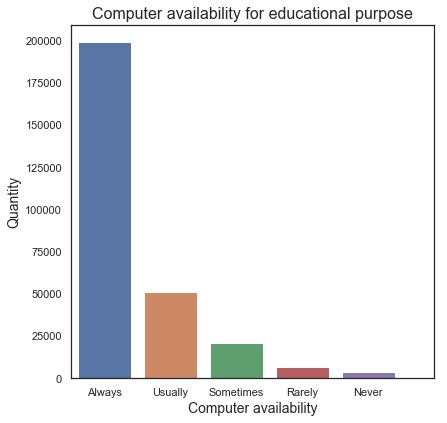

In [101]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

_ = sns.barplot(y='COUNTER', x=computer_available.index, data=computer_available)
_ = plt.xticks(np.arange(6), labels)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.title('Computer availability for educational purpose', size=16)

In [102]:
computer_anxiety = edu_df2.groupby(['COMPAVAIL', 'anxiety_disorder']).count()
computer_anxiety = computer_anxiety/computer_anxiety.groupby(level=[0]).sum()

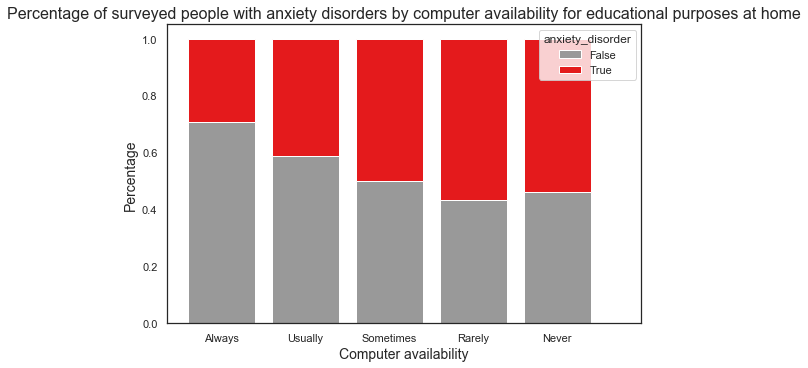

In [103]:
test5 = computer_anxiety.COUNTER.unstack('anxiety_disorder').fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

fig, ax = plt.subplots(figsize=(8.5, 5.5))
_ = test5.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1_r', 2))
_ = plt.xticks(np.arange(6), labels, rotation=0)
_ = plt.title('Percentage of surveyed people with anxiety disorders by computer availability for educational purposes at home', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)

Provider of computer or digital device

In [104]:
# Applied over ENROLL1, COMPAVAIL 1 TO 4 and ONLY COMP1, COMP2 AND COMP3 VALID (NOT -88 OR -99)
edu_df_valid_comp = edu_df2[(edu_df2.COMP1 == 1) | (edu_df2.COMP2 == 1) | (edu_df2.COMP3 == 1)]

In [105]:
x1 = edu_df_valid_comp.loc[:, ['COMP1', 'COMP2', 'COMP3']].idxmax(axis=1)
edu_df_valid_comp['COMP_PROVIDER'] = x1

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [106]:
len(edu_df_valid_comp)

275254

In [107]:
edu_df_valid_comp.groupby(['COMPAVAIL', 'COMP_PROVIDER']).count().COUNTER

COMPAVAIL  COMP_PROVIDER
1.0        COMP1             77105
           COMP2            119530
           COMP3               948
2.0        COMP1             18535
           COMP2             31402
           COMP3               626
3.0        COMP1              7257
           COMP2             12657
           COMP3               925
4.0        COMP1              1880
           COMP2              3470
           COMP3               919
Name: COUNTER, dtype: int64

In [108]:
comp_provider = edu_df_valid_comp.groupby(['COMPAVAIL', 'COMP_PROVIDER']).count()
comp_provider = comp_provider/comp_provider.groupby(level=[0]).sum()

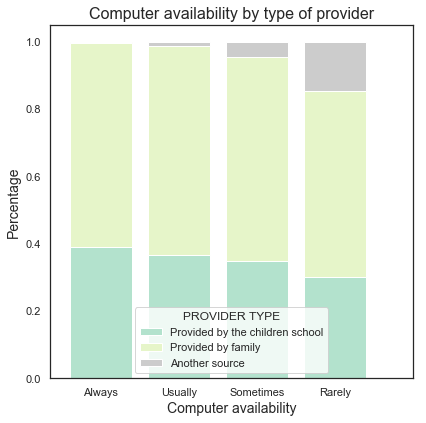

In [109]:
test6 = comp_provider.COUNTER.unstack(['COMP_PROVIDER']).fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely']

fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = test6.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 3))
_ = plt.xticks(np.arange(5), labels, rotation=0)
_ = plt.title('Computer availability by type of provider', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.legend(title='PROVIDER TYPE', loc='lower center', labels=['Provided by the children school', 
                                                                 'Provided by family ', 
                                                                 'Another source'])

In [110]:
internet_available = edu_df2.groupby(['INTRNTAVAIL']).count()

In [111]:
internet_available.COUNTER/internet_available.COUNTER.sum()

INTRNTAVAIL
1.0    0.750030
2.0    0.177152
3.0    0.048900
4.0    0.014273
5.0    0.009645
Name: COUNTER, dtype: float64

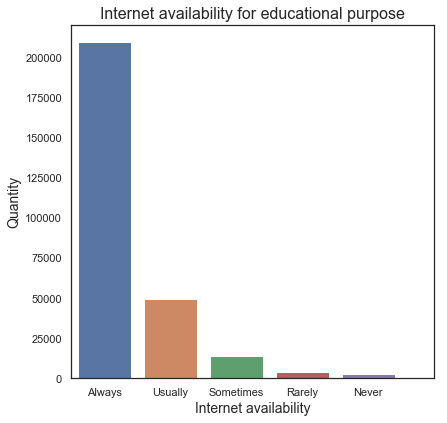

In [112]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

_ = sns.barplot(y='COUNTER', x=internet_available.index, data=internet_available)
_ = plt.xticks(np.arange(6), labels)
_ = plt.xlabel('Internet availability', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.title('Internet availability for educational purpose', size=16)

In [113]:
internet_anxiety = edu_df2.groupby(['INTRNTAVAIL', 'anxiety_disorder']).count()
internet_anxiety = internet_anxiety/internet_anxiety.groupby(level=[0]).sum()

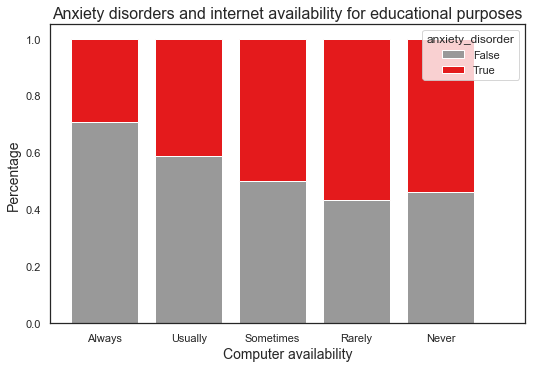

In [114]:
test6 = internet_anxiety.COUNTER.unstack('anxiety_disorder').fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

fig, ax = plt.subplots(figsize=(8.5, 5.5))
_ = test5.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1_r', 2))
_ = plt.xticks(np.arange(6), labels, rotation=0)
_ = plt.title('Anxiety disorders and internet availability for educational purposes', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)

In [115]:
comp_race = edu_df2.groupby(['COMPAVAIL', 'RRACE']).count()
comp_race = comp_race/comp_race.groupby(level=[0]).sum()

In [116]:
comp_race

SCRAM   COUNTER    EST_ST  RHISPANIC   EGENDER     EEDUC  \
COMPAVAIL RRACE                                                                
1.0       1.0    0.798005  0.798005  0.798005   0.798005  0.798005  0.798005   
          2.0    0.091926  0.091926  0.091926   0.091926  0.091926  0.091926   
          3.0    0.059367  0.059367  0.059367   0.059367  0.059367  0.059367   
          4.0    0.050702  0.050702  0.050702   0.050702  0.050702  0.050702   
2.0       1.0    0.774667  0.774667  0.774667   0.774667  0.774667  0.774667   
          2.0    0.105707  0.105707  0.105707   0.105707  0.105707  0.105707   
          3.0    0.053098  0.053098  0.053098   0.053098  0.053098  0.053098   
          4.0    0.066529  0.066529  0.066529   0.066529  0.066529  0.066529   
3.0       1.0    0.714792  0.714792  0.714792   0.714792  0.714792  0.714792   
          2.0    0.159583  0.159583  0.159583   0.159583  0.159583  0.159583   
          3.0    0.040521  0.040521  0.040521   0.040521  0.040521  0.040521   
          4.0    0.085104  0.085104  0.085104   0.085104  0.085104  0.085104   
4.0       1.0    0.662920  0.662920  0.662920   0.662920  0.662920  0.662920   
          2.0    0.208962  0.208962  0.208962   0.208962  0.208962  0.208962   
          3.0    0.027718  0.027718  0.027718   0.027718  0.027718  0.027718   
          4.0    0.100400  0.100400  0.100400   0.100400  0.100400  0.100400   
5.0       1.0    0.650224  0.650224  0.650224   0.650224  0.650224  0.650224   
          2.0    0.210762  0.210762  0.210762   0.210762  0.210762  0.210762   
          3.0    0.023262  0.023262  0.023262   0.023262  0.023262  0.023262   
          4.0    0.115751  0.115751  0.115751   0.115751  0.115751  0.115751   

                      AGE   ENROLL1   ENROLL2  ENROLL3  ...   INTRNT2  \
COMPAVAIL RRACE                                         ...             
1.0       1.0    0.798005  0.798005  0.792180      NaN  ...  0.801358   
          2.0    0.091926  0.091926  0.093233      NaN  ...  0.089304   
          3.0    0.059367  0.059367  0.045113      NaN  ...  0.059302   
          4.0    0.050702  0.050702  0.069474      NaN  ...  0.050036   
2.0       1.0    0.774667  0.774667  0.786942      NaN  ...  0.779461   
          2.0    0.105707  0.105707  0.092784      NaN  ...  0.102532   
          3.0    0.053098  0.053098  0.037801      NaN  ...  0.053120   
          4.0    0.066529  0.066529  0.082474      NaN  ...  0.064888   
3.0       1.0    0.714792  0.714792  0.743028      NaN  ...  0.723293   
          2.0    0.159583  0.159583  0.119522      NaN  ...  0.152536   
          3.0    0.040521  0.040521  0.045817      NaN  ...  0.040276   
          4.0    0.085104  0.085104  0.091633      NaN  ...  0.083895   
4.0       1.0    0.662920  0.662920  0.663636      NaN  ...  0.672185   
          2.0    0.208962  0.208962  0.163636      NaN  ...  0.202766   
          3.0    0.027718  0.027718  0.027273      NaN  ...  0.029801   
          4.0    0.100400  0.100400  0.145455      NaN  ...  0.095247   
5.0       1.0    0.650224  0.650224  0.538462      NaN  ...  0.679551   
          2.0    0.210762  0.210762  0.192308      NaN  ...  0.205112   
          3.0    0.023262  0.023262  0.012821      NaN  ...  0.026185   
          4.0    0.115751  0.115751  0.256410      NaN  ...  0.089152   

                  INTRNT3  TSCHLHRS  TTCH_HRS  THHLD_NUMKID    INCOME  \
COMPAVAIL RRACE                                                         
1.0       1.0    0.694048  0.800352  0.800045      0.798005  0.798846   
          2.0    0.169048  0.090938  0.091064      0.091926  0.091232   
          3.0    0.056548  0.058307  0.058457      0.059367  0.059074   
          4.0    0.080357  0.050403  0.050434      0.050702  0.050848   
2.0       1.0    0.651194  0.776782  0.776472      0.774667  0.775993   
          2.0    0.189655  0.104926  0.105129      0.105707  0.105161   
          3.0    0.045093  0.052374  0.052431      0.053098  0.05279

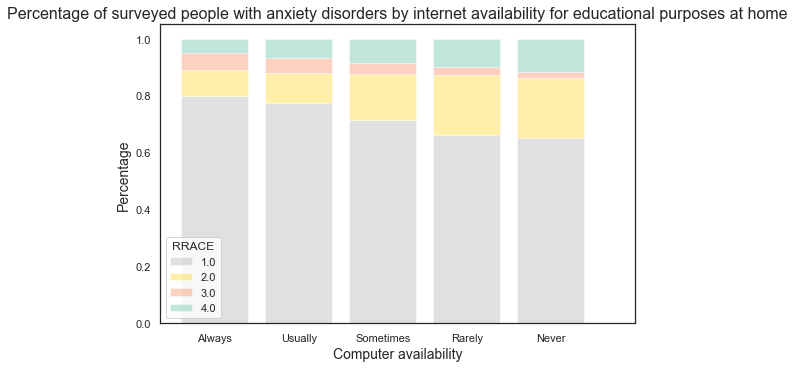

In [117]:
test7 = comp_race.COUNTER.unstack('RRACE').fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

fig, ax = plt.subplots(figsize=(8.5, 5.5))
_ = test7.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set2_r', 5), alpha=0.4)
_ = plt.xticks(np.arange(6), labels, rotation=0)
_ = plt.title('Percentage of surveyed people with anxiety disorders by internet availability for educational purposes at home', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)

In [118]:
edu_df3 = edu_df2.copy()

#ct_res = pd.crosstab(index=[df[var], df[var1], df[var2]], columns=df['depression_disorder'], margins=True)
ct_race_comp = pd.crosstab(index=[edu_df3['RRACE'], edu_df3['depression_disorder']], columns=edu_df3['COMPAVAIL'], margins=True)
ct_race_comp['COMPAVAIL1(%)'] = round(ct_race_comp[1]/ct_race_comp['All']*100, 2)
ct_race_comp['COMPAVAIL2(%)'] = round(ct_race_comp[2]/ct_race_comp['All']*100, 2)
ct_race_comp['COMPAVAIL3(%)'] = round(ct_race_comp[3]/ct_race_comp['All']*100, 2)
ct_race_comp['COMPAVAIL4(%)'] = round(ct_race_comp[4]/ct_race_comp['All']*100, 2)
ct_race_comp['COMPAVAIL5(%)'] = round(ct_race_comp[5]/ct_race_comp['All']*100, 2)
ct_race_comp.drop(columns='All')

COMPAVAIL                     1.0    2.0    3.0   4.0   5.0  COMPAVAIL1(%)  \
RRACE depression_disorder                                                    
1.0   False                130763  28746   9557  2451  1302          75.66   
      True                  28281  10879   5578  1854  1018          59.40   
2.0   False                 14035   3694   1937   665   408          67.67   
      True                   4286   1713   1442   692   344          50.56   
3.0   False                 10000   1986    575    87    54          78.73   
      True                   1832    730    283    93    29          61.75   
4.0   False                  7676   2252   1058   354   221          66.40   
      True                   2429   1151    744   298   192          50.46   
All                        199302  51151  21174  6494  3568          70.75   

COMPAVAIL                  COMPAVAIL2(%)  COMPAVAIL3(%)  COMPAVAIL4(%)  \
RRACE depression_disorder                                                
1.0   False                        16.63           5.53           1.42   
      True                         22.85          11.72           3.89   
2.0   False                        17.81           9.34           3.21   
      True                         20.21          17.01           8.16   
3.0   False                        15.64           4.53           0.68   
      True                         24.60           9.54           3.13   
4.0   False                        19.48           9.15           3.06   
      True                         23.91          15.45           6.19   
All                                18.16           7.52           2.31   

COMPAVAIL                  COMPAVAIL5(%)  
RRACE depression_disorder                 
1.0   False                         0.75  
      True                          2.14  
2.0   False                         1.97  
      True                          4.06  
3.0   False                         0.43  
      True                          0.98  
4.0   False                         1.91  
      True                          3.99  
All                                 1.27

In [119]:
comp_race1 = comp_race.reset_index()

In [120]:
#a.rename(columns={'COMPAVAIL':'Computer availavility'}, inplace=True)

In [121]:
def condition(comp):
    if comp == 1:
        return 'always'
    elif comp ==2:
        return 'usually'
    elif comp ==3:
        return 'sometimes'
    elif comp ==4:
        return 'rarely'
    else:
        return 'never'

In [122]:
comp_race1['Computer availavility'] = comp_race1.COMPAVAIL.apply(condition)

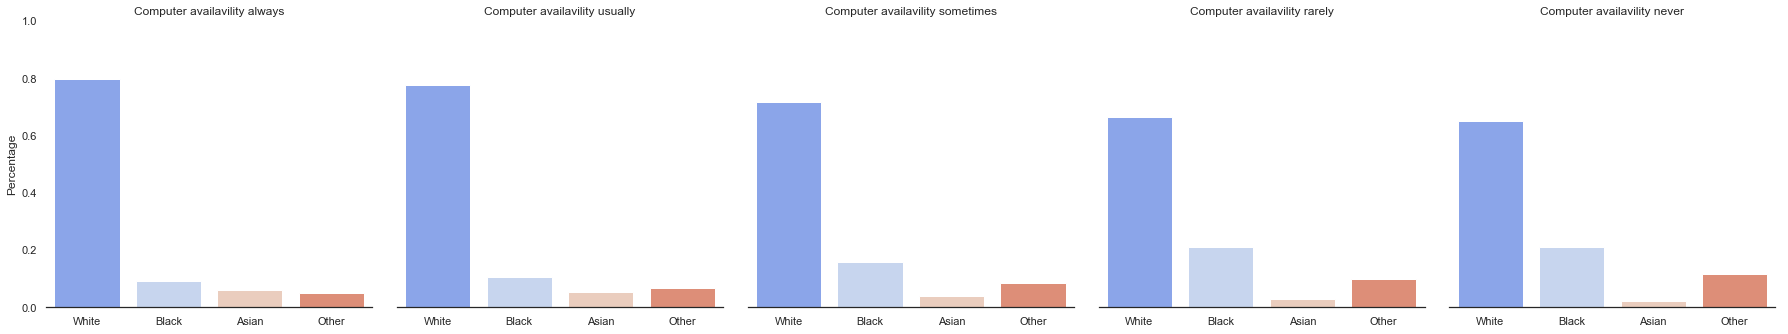

In [123]:
g = sns.catplot(x="RRACE", y='SCRAM',
                col="Computer availavility", kind="bar", data=comp_race1, palette='coolwarm')
(g.set_axis_labels("", "Percentage")
  .set_xticklabels(["White", "Black", "Asian", "Other"])
  .set_titles("{col_var} {col_name}")
  .set(ylim=(0, 1))
  .despine(left=True))

_ = plt.show()

In [124]:
comp_race1

,COMPAVAIL,RRACE,SCRAM,COUNTER,EST_ST,RHISPANIC,EGENDER,EEDUC,AGE,ENROLL1,...,INTRNT3,TSCHLHRS,TTCH_HRS,THHLD_NUMKID,INCOME,anxiety_disorder,depression_disorder,ENROLL_TYPE,TEACH_TYPE,Computer availavility
0,1.0,1.0,0.798005,0.798005,0.798005,0.798005,0.798005,0.798005,0.798005,0.798005,...,0.694048,0.800352,0.800045,0.798005,0.798846,0.798005,0.798005,0.798005,0.798005,always
1,1.0,2.0,0.091926,0.091926,0.091926,0.091926,0.091926,0.091926,0.091926,0.091926,...,0.169048,0.090938,0.091064,0.091926,0.091232,0.091926,0.091926,0.091926,0.091926,always
2,1.0,3.0,0.059367,0.059367,0.059367,0.059367,0.059367,0.059367,0.059367,0.059367,...,0.056548,0.058307,0.058457,0.059367,0.059074,0.059367,0.059367,0.059367,0.059367,always
3,1.0,4.0,0.050702,0.050702,0.050702,0.050702,0.050702,0.050702,0.050702,0.050702,...,0.080357,0.050403,0.050434,0.050702,0.050848,0.050702,0.050702,0.050702,0.050702,always
4,2.0,1.0,0.774667,0.774667,0.774667,0.774667,0.774667,0.774667,0.774667,0.774667,...,0.651194,0.776782,0.776472,0.774667,0.775993,0.774667,0.774667,0.774667,0.774667,usually
5,2.0,2.0,0.105707,0.105707,0.105707,0.105707,0.105707,0.105707,0.105707,0.105707,...,0.189655,0.104926,0.105129,0.105707,0.105161,0.105707,0.105707,0.105707,0.105707,usually
6,2.0,3.0,0.053098,0.053098,0.053098,0.053098,0.053098,0.053098,0.053098,0.053098,...,0.045093,0.052374,0.052431,0.053098,0.052795,0.053098,0.053098,0.053098,0.053098,usually
7,2.0,4.0,0.066529,0.066529,0.066529,0.066529,0.066529,0.066529,0.066529,0.066529,...,0.114058,0.065918,0.065968,0.066529,0.066051,0.066529,0.066529,0.066529,0.066529,usually
8,3.0,1.0,0.714792,0.714792,0.714792,0.714792,0.714792,0.714792,0.714792,0.714792,...,0.581551,0.715474,0.715248,0.714792,0.715028,0.714792,0.714792,0.714792,0.714792,sometimes
9,3.0,2.0,0.159583,0.159583,0.159583,0.159583,0.159583,0.159583,0.159583,0.159583,...,0.266043,0.159573,0.159644,0.159583,0.159280,0.159583,0.159583,0.159583,0.159583,sometimes


### STATISTICAL TEST 4: Significance difference between the availability of computer and race

In [125]:
chi2_contingency(pd.crosstab(index=[edu_df3['RRACE']], columns=edu_df3['COMPAVAIL']), correction=False)

(3602.36123430818,
 0.0,
 12,
 array([[155959.02061493,  40026.99352477,  16569.20804859,
           5081.72461828,   2792.05319342],
        [ 20671.04939135,   5305.23952302,   2196.10841744,
            673.53962704,    370.06304116],
        [ 11086.20868405,   2845.28334085,   1177.80746142,
            361.22988828,    198.47062541],
        [ 11585.72130967,   2973.48361136,   1230.87607255,
            377.5058664 ,    207.41314002]]))

# Children's live virtual contact with teachers in last 7 days and Hours spent on all teaching activities with children in last 7 days

In [126]:
teaching_hours = edu_df2.copy()

/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


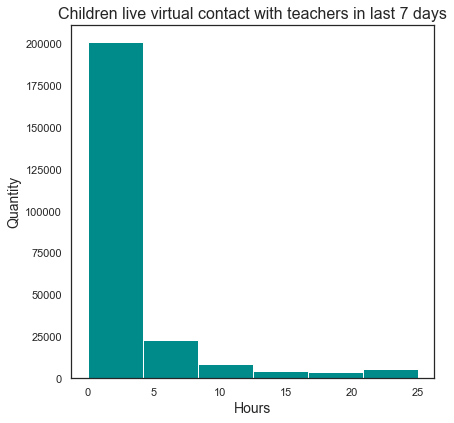

In [127]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = plt.hist(edu_df2.TSCHLHRS, bins=6, color='darkcyan')
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Hours', size=14)
_ = plt.ylabel('Quantity', size=14)

# children virtual contact with teachers and anxiety in parents

In [128]:
def teaching_hours_windows(hours):
    if hours == 0:
        return 'No'
    elif (hours > 0) & (hours < 10):
        return 'Less than 10 hours'
    elif (hours >= 10):
        return 'Between 10 and 25 hours'

In [129]:
education_df.head()

,SCRAM,COUNTER,WEEK,EST_ST,RRACE,RHISPANIC,EGENDER,EEDUC,AGE,ENROLL1,...,INTRNTAVAIL,INTRNT1,INTRNT2,INTRNT3,TSCHLHRS,TTCH_HRS,THHLD_NUMKID,INCOME,anxiety_disorder,depression_disorder
0,V010000001S10011099370111,1,2020-04-23,47.0,1.0,1.0,2.0,6.0,34.0,1.0,...,1.0,NaN,1.0,NaN,2.0,4.0,2.0,4.0,True,False
1,V010000001S10011900470112,1,2020-04-23,1.0,1.0,1.0,1.0,4.0,65.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,True,True
2,V010000001S18010744940111,1,2020-04-23,26.0,4.0,1.0,2.0,6.0,44.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.0,False,False
3,V010000001S37010301340112,1,2020-04-23,1.0,1.0,1.0,1.0,4.0,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,True,True
4,V010000001S37010480340111,1,2020-04-23,1.0,1.0,1.0,2.0,7.0,57.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,False,False


In [130]:
teaching_hours_dt = scenario_timebase[(scenario_timebase['ENROLL_TYPE'] == 'ENROLL1')]
teaching_hours_dt['Virtual_teaching'] = teaching_hours_dt.TSCHLHRS.apply(teaching_hours_windows)

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
virtual_teaching_dt = teaching_hours_dt.groupby(['Virtual_teaching', 'WEEK']).count().COUNTER

In [132]:
virtual_teaching_dt

Virtual_teaching         WEEK      
Between 10 and 25 hours  2020-04-23     2415
                         2020-05-07     1409
                         2020-05-14     4236
                         2020-05-21     3005
                         2020-05-28     2624
                         2020-06-04     1921
                         2020-06-11     1554
                         2020-06-18     1691
                         2020-06-25     1120
                         2020-07-02      840
                         2020-07-09      797
                         2020-07-16      734
Less than 10 hours       2020-04-23    12302
                         2020-05-07     6384
                         2020-05-14    19626
                         2020-05-21    13438
                         2020-05-28    11603
                         2020-06-04     7035
                         2020-06-11     5818
                         2020-06-18     6272
                         2020-06-25     3850
                   

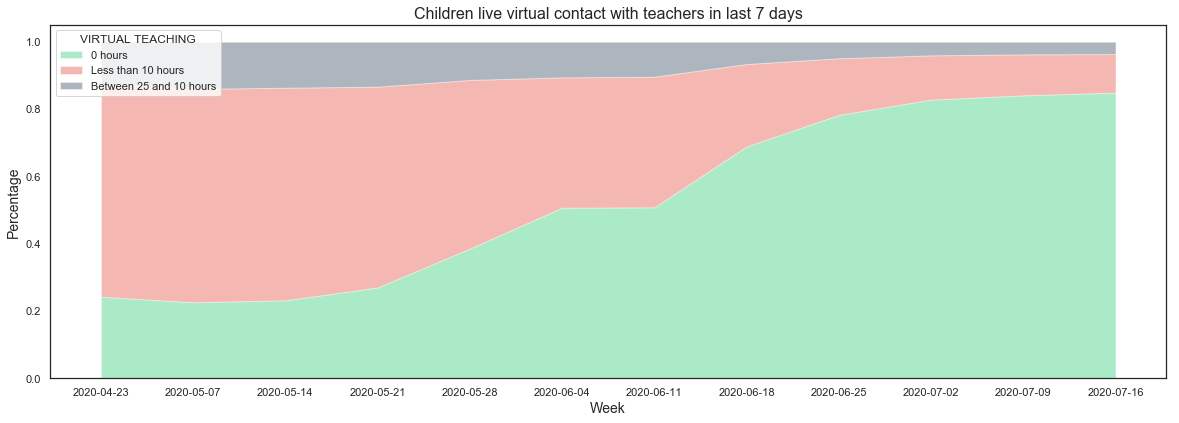

In [133]:
virtual_teaching_dt = virtual_teaching_dt/virtual_teaching_dt.groupby(level=[1]).sum()
virtual_teaching_dt = virtual_teaching_dt.reset_index()
#virtual_teaching_week = virtual_teaching_dt[virtual_teaching_dt.depression_disorder == True]

y1=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='No'].COUNTER)
y2=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='Less than 10 hours'].COUNTER)
y3=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='Between 10 and 25 hours'].COUNTER)
x = list(virtual_teaching_dt.WEEK[:12])

sns.set(style="white")
pal = ["#2ecc71", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='VIRTUAL TEACHING', loc='upper left', labels=['0 hours', 
                                                              'Less than 10 hours', 
                                                              'Between 25 and 10 hours'])
_ = plt.show()

/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


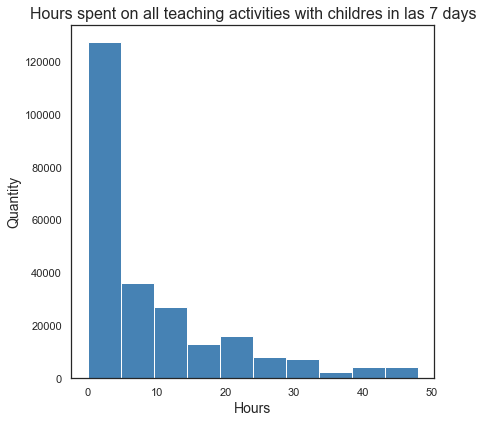

In [134]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = plt.hist(teaching_hours.TTCH_HRS, color='steelblue')
_ = plt.title('Hours spent on all teaching activities with childres in las 7 days', size=16)
_ = plt.xlabel('Hours', size=14)
_ = plt.ylabel('Quantity', size=14)

In [135]:
def parents_teaching_hours_windows(hours):
    if hours == 0:
        return '0 hours'
    elif (hours > 0) & (hours < 10):
        return 'Less than 10 hours'
    elif (hours >= 10) & (hours < 25):
        return 'Between 10 and 25 hours'
    else:
        return 'Between 25 and 50 hours'

In [136]:
teaching_hours_dt = scenario_timebase[(scenario_timebase.TTCH_HRS >=0) & (scenario_timebase['ENROLL_TYPE'] == 'ENROLL1')]
teaching_hours_dt['Parents_teaching'] = teaching_hours_dt.TTCH_HRS.apply(parents_teaching_hours_windows)

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
parent_teaching_dt = teaching_hours_dt.groupby(['Parents_teaching', 'WEEK']).count().COUNTER

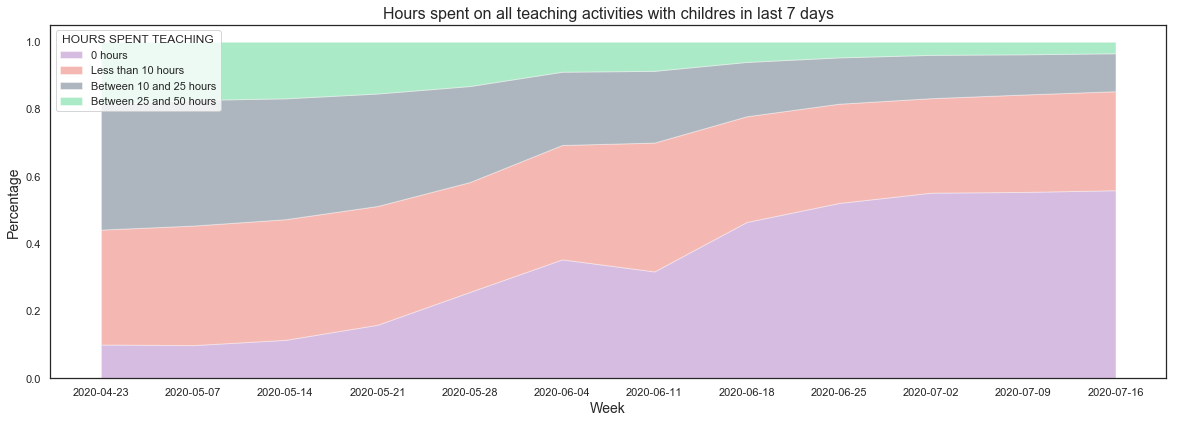

In [138]:
parent_teaching_dt = parent_teaching_dt/parent_teaching_dt.groupby(level=[1]).sum()
parent_teaching_dt = parent_teaching_dt.reset_index()
#parent_teaching_week = parent_teaching_dt[parent_teaching_dt.depression_disorder == True]

y1=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='0 hours'].COUNTER)
y2=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Less than 10 hours'].COUNTER)
y3=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Between 10 and 25 hours'].COUNTER)
y4=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Between 25 and 50 hours'].COUNTER)
x = list(parent_teaching_dt.WEEK[:12])

sns.set(style="white")
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3,y4], 
                  labels=['A','B','C','D'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Hours spent on all teaching activities with childres in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='HOURS SPENT TEACHING', loc='upper left', labels=['0 hours', 
                                                                  'Less than 10 hours', 
                                                                  'Between 10 and 25 hours',
                                                                  'Between 25 and 50 hours'])
_ = plt.show()

**Follou up: Analysis of those patterns and anxiety/depression**

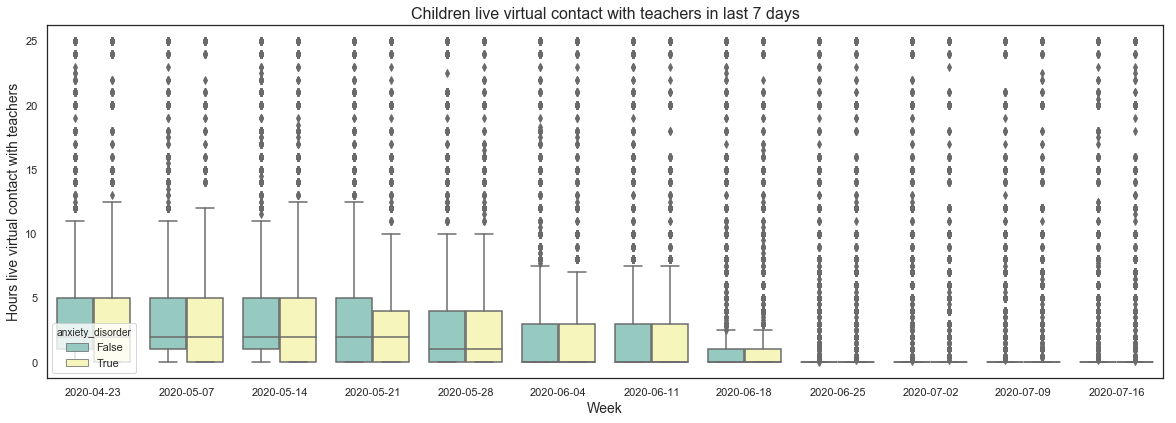

In [139]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK', y='TSCHLHRS', hue='anxiety_disorder', data=teaching_hours_dt[teaching_hours_dt.TSCHLHRS >= 0], palette="Set3")
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

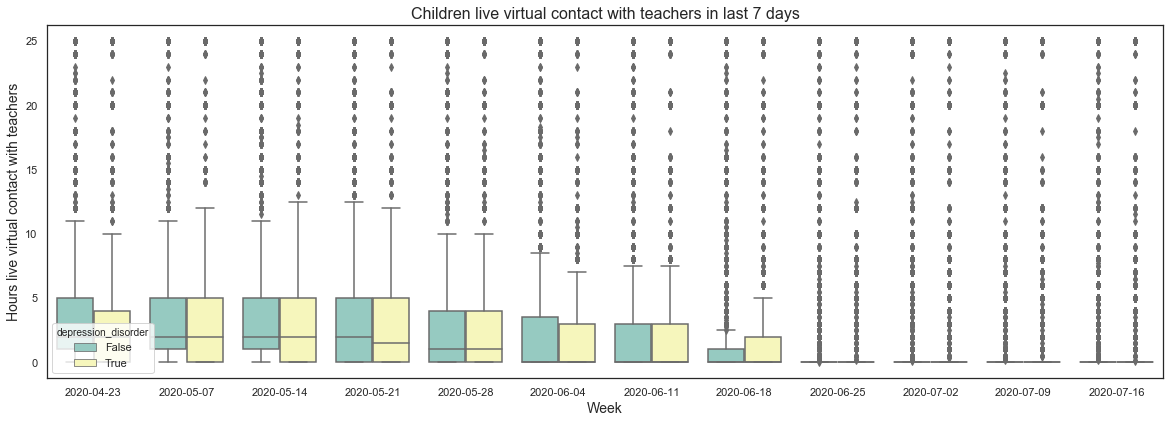

In [140]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK', y='TSCHLHRS', hue='depression_disorder', data=teaching_hours_dt[teaching_hours_dt.TSCHLHRS >= 0], palette="Set3")
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

We are not saying here that the disruption on Education is causing high leves of anxiety and depression, but at least we can identify vulnerable cohorts: women with children at home, women with children at home enrolled on public/private schools, surveyed people facing remote learning for their kids, specially online and homework resources sent to home. The availability of computer and internet for educational purposes reveals differences between the anxity levels of the cohorst (**again, are those differences statistically significant?**). In the plot above, we see that groups with anxiety/depression disorders have lower percentile 25/75 of live virtual contact with teachers than groups without anxiety/depression disorders (**check hypothesis around that**).

### Virtual live contact with teachers related to income level

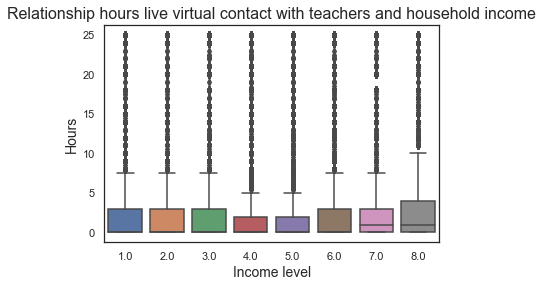

In [141]:
_ = sns.boxplot(x= 'INCOME', y='TSCHLHRS', data=teaching_hours_dt[(teaching_hours_dt.TSCHLHRS >= 0) & (teaching_hours_dt.INCOME > 0)])
_ = plt.xlabel('Income level', size=14)
_ = plt.ylabel('Hours', size=14)
_ = plt.title('Relationship hours live virtual contact with teachers and household income', size=16)

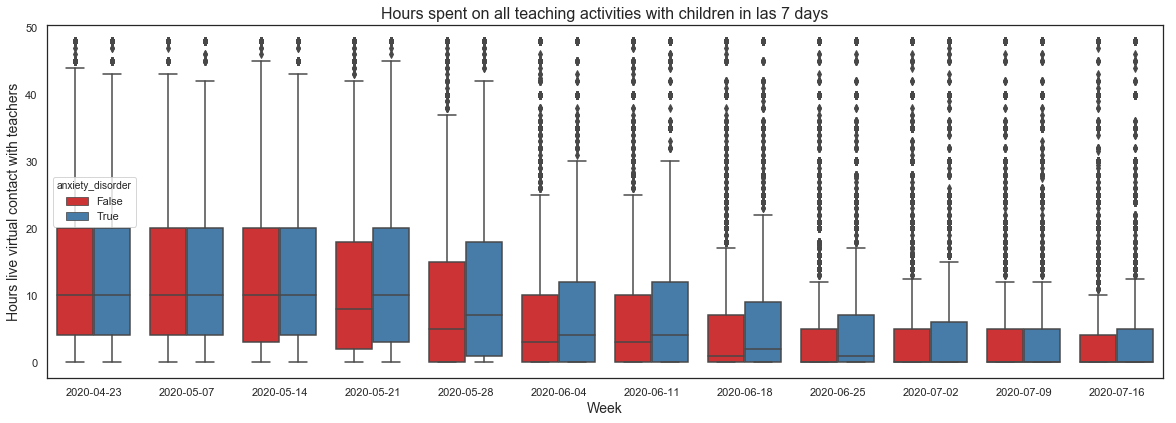

In [142]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK', y='TTCH_HRS', hue='anxiety_disorder', data=teaching_hours_dt[teaching_hours_dt.TTCH_HRS >= 0], palette="Set1")
_ = plt.title('Hours spent on all teaching activities with children in las 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

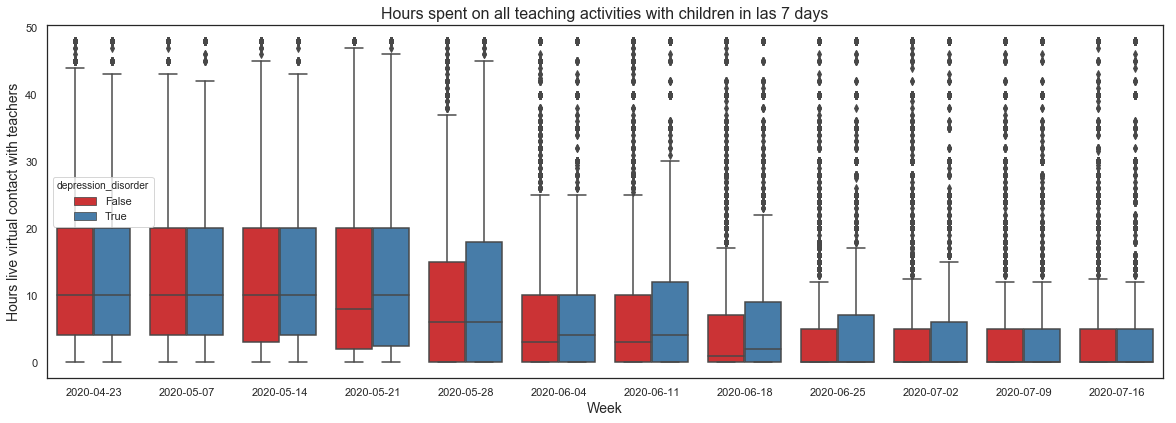

In [143]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK', y='TTCH_HRS', hue='depression_disorder', data=teaching_hours_dt[teaching_hours_dt.TTCH_HRS >= 0], palette="Set1")
_ = plt.title('Hours spent on all teaching activities with children in las 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

And finally, both groups of interest start to spend less time in all teaching activities close to the summer period, but people manifesting anxiety/depression disorders still spending more hours than the other group.

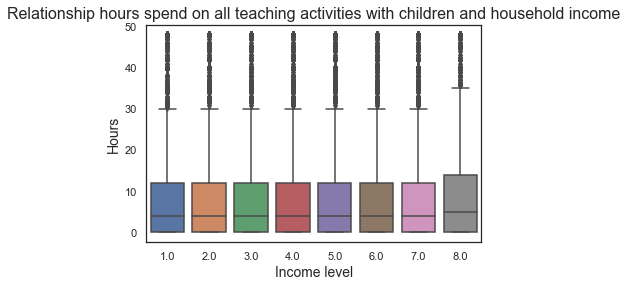

In [144]:
_ = sns.boxplot(x= 'INCOME', y='TTCH_HRS', data=teaching_hours_dt[(teaching_hours_dt.TTCH_HRS >= 0) & (teaching_hours_dt.INCOME > 0)])
_ = plt.xlabel('Income level', size=14)
_ = plt.ylabel('Hours', size=14)
_ = plt.title('Relationship hours spend on all teaching activities with children and household income', size=16)

### STATISTICAL TEST 5: Testing distribution of spent teaching and virtual lives by cohorts

In [145]:
#TO DO: Apply the following tests
#- hours spent on teaching and income, gender, race -> ANOVA
#- virtual live and income -> ANOVA